<a href="https://colab.research.google.com/github/santacruzAI/MLPhasesOfMatter/blob/main/7%20-%2018%20-%202022%20Machine%20Learning%20Phase%20Transitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FOR WORKING PURPOSES ONLY:**

Plan:

**1. Generate Square Lattice Data**
2. Create a Fully-Conected Neural Network, achieving 94% accuracy on 10x10 grids.
3. Create a Fully Connected Neural Network, achieving 99% accuracy on 40x40 grids.
4. Create the mentioned Toy Model, with analytically determined parameters.
5. Generate Triangular Lattice Data (L = 30) *(Side Note: They don't seem to train a separate model for each L)*
6. If necessary, train a Fully Connected Neural Network on 30x30 square lattice data.
7. Test out Fully Connected Neural Network on the Triangular Lattice Data.
**8. Generate Square Ice Lattice Data (2 x 16 x 16).**
9. Train Fully Connected Neural Network on Square Ice Lattice Data (100 hidden units..)
**10. Generate Ising Lattice Gauge Theory Lattices (16 x 16 x 2).**
11. Train a Fully-Connected Neural Network on this data, show it only attains 50% accuracy.
12. Train a ConvNet on this data, show it attains nearly 100% accuracy.
13. Modify the testing set to violate the closed-loop structure.
14. Test the ConvNet on this, demonstrate results are still high.
15. Modify the testing set to violate locality constraints.
16. Test the ConvNet on this, demonstrate results are lower.
17. Discuss future extensions, and eventually start implementing them.


In [3]:
import numpy as np
import random
!pip install numba
from numba import jit
import matplotlib.pyplot as plt
!pip install tqdm
!pip install ray
from tqdm import tqdm
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 146 kB/s 
     |████████████████████████████████| 10.1 MB 36.7 MB/s 
     |████████████████████████████████| 4.1 MB 53.5 MB/s 
     |████████████████████████████████| 144 kB 44.0 MB/s 
     |████████████████████████████████| 466 kB 35.5 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


# **Data Generation**

In [4]:
np.random.seed(seed = 3)

Here, we will perform the Metropolis-Hastings Algorithm to generate square lattices.

First, we create this function to calculate the square Hamiltonian for each lattice.

In [ ]:
@jit
def ferr_square_energy(lattice):
  en = 0
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en += lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en += lattice[i][j]*lattice[i+1][j]
      if j>0:
        en += lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en += lattice[i][j] * lattice[i][j+1]
  return en

Here, we initialize our constants.

In [5]:
k = (1.38064852)/(10**23) #

Now, we create a function to execute the Metropolis-Hastings Algorithm and collect samples.

Change to try where the edge sites as having the other edge sites have them as neighbors.

In [ ]:
def delta_E(lattice, i, j):
  en = 0
  if i>0:
      en += lattice[i][j]*lattice[i-1][j]
  if i<len(lattice)-1:
      en += lattice[i][j]*lattice[i+1][j]
  if j>0:
      en += lattice[i][j]*lattice[i][j-1]
  if j<len(lattice)-1:
      en += lattice[i][j] * lattice[i][j+1]
  return en

In [ ]:
def delta_E(lattice, i, j):
  N = np.shape(lattice)[0]
  en = lattice[i][j]*(lattice[(i-1) % N][j] + lattice[(i+1) % N][j] + lattice[i][(j-1) % N] + lattice[i][j] * lattice[i][(j+1) % N])
  return en  

In [ ]:
from typing import Callable
def metropolis(get_energy: Callable[[np.ndarray], float], grid_size: int, starts: int, samples: int, temp_start: float, temp_end: float, therm_steps: int):
  temp_range = np.linspace(temp_start,temp_end,int(10*(temp_end-temp_start))) #The range of temperatures from 1 to 3.7
  tempList = [] #This collects the specific temperatures for later plotting.
  sampleList = [] #This collects the samples over the Metropolis-Hastings algorithm.

  #For each temperature, for each start, we collect samples collected after thermal evolution. 
  for temp_count in tqdm(range(len(temp_range))):
    temp = temp_range[temp_count]
    #Computing beta.
    b = 1/(k*temp) 
    #Collect each sample.
    for sample in range(samples): 
      #Generates a random lattice of decimals between -1 and 1.
      lattice = np.array([random.choice([-1, 1]) for j in range(grid_size**2)]).reshape(grid_size, grid_size)
      
      #This collects all the energies of samples for plotting.
      enList = [] 
      #Here, we will collect iterative times for plotting.
      timeList = []
      #Initializing algorithmic time to 0.
      time = 0
    
      #We perform thermal evolution.
      for therm_step in range(therm_steps):
      
        #Collect the energy of the current lattice.
        curr_en = get_energy(lattice)
        
        #Picks a lattice sites to flip.
        index = random.randint(0, (grid_size - 1) * (grid_size - 1))
        flip_x, flip_y = (index//grid_size, index % grid_size)
        
        #Now we calculate the probability that this state will be accepted. If the candidate state has a lower energy than the current state, this probability is 1, else it is the exponentiation of the difference between the candidate and present energy scaled.
        p_uv = 2 * delta_E(lattice, flip_x, flip_y)
      
        #We store the algorithmic time and increment it.
        timeList.append(time)
        time += 1
      
        #If a coin toss with this acceptance probability as its distribution produces a 1 (perhaps thought of as a heads), we accept the state.
        if np.random.uniform()<=p_uv:
          lattice[flip_x][flip_y] *= -1
      
      #Here we store the sample and the current temperature for plotting and sample collection.
      sampleList.append(lattice)
      tempList.append(temp)
        
  return sampleList, tempList, enList, timeList

Now we run Metropolis-Hastings for the Square Lattice to generate 10 x 10 lattices, over 10 starts, taking 100 samples per start per temperatures ranging between 1.0 and 3.7. 100 thermal evolution steps will be taken to simulate the effects of a thermal bath.

In [ ]:
sampleList, tempList, enList, timeList = metropolis(ferr_square_energy, 32, 10, 10000, 1, 3.7, 100)

**Here, we plot algorithmic time vs the energy of the lattices over the last iteration of thermal evolution in the Metropolis-Hastings Algorithm.**

In [ ]:
#We plot energy vs algorithmic time.
plt.plot(timeList, enList)

Though it is roughly-hewn, and may appear jittery, the energy decreases consistently over time, which is encouraging.

## **Data Preprocessing**

**Here we preprocess the data by simply flattening the lattices into feature vectors, perform train-test split and store it in a .csv file.**




In [ ]:
def train_test_data(sampleList):

  #Here, we flatten the samples into a feature matrix.
  feature_matrix = np.array([features.flatten() for features in sampleList])

  print("FEATURE MATRIX SHAPE: ", np.shape(feature_matrix))
  
  #Set Curie Temperature as 2.27
  Tc = 2.27
  
  #We create another set of temperature values, first reformatting to correct dimensions and marking all temperatures above the critical temperature 1, and all below 0.
  tempList2 = np.array([[temp] for temp in tempList])
  tempList3 = np.zeros(tempList2.shape)
  tempList3[tempList2>=Tc] = 1
  tempList3[tempList2<Tc] = 0
  
  #Now, we append the target column (1/0 to indicate temp above or below the critical temperature) to the feature matrix.
  feature_matrix = np.append(feature_matrix, tempList3, axis = 1)
  
  #We shuffle the feature matrix so that the neural network doesn't pick up any pattern around the temperature-ordered way we generated the data.
  np.random.shuffle(feature_matrix) #
  print("FEATURE/OUTPUT MATRIX SHAPE: ", np.shape(feature_matrix))

  #Here, we perform train-test split, and pick 3/5 of the data for training and 2/5 for testing.
  end = 3 * len(feature_matrix) // 5
  feature_train_matrix = feature_matrix[:end, :-1]
  feature_test_matrix = feature_matrix[end:, :-1]
  print("UNIQUE FEATURES: ", np.unique(feature_test_matrix))
  tempList2 = feature_matrix[:,-1]
  print("UNIQUE TARGETS: ", np.unique(np.array(tempList2)))
  tempList2 = [int(temp) for temp in tempList2]
  y_train = tempList2[:end]
  print("Y_TRAIN: ", y_train)
  y_test = tempList2[end:]
  print("FEATURE_TRAIN_MATRIX, of dimensions", np.shape(feature_train_matrix), " is", feature_train_matrix)
  print("\nFEATURE_TEST_MATRIX, of dimensions", np.shape(feature_test_matrix), "is", feature_test_matrix)
  print("\nY_TRAIN of dimensions", np.shape(np.array([np.array(y_train)]).T), "is", np.array([np.array(y_train)]).T)
  print("\nY_TEST of dimensions",  np.shape(np.array([np.array(y_test)]).T), "is", np.array([np.array(y_test)]).T)

  #Here, we return the training and testing data.
  return feature_train_matrix, np.expand_dims(np.array(y_train), axis = 1), feature_test_matrix, np.expand_dims(np.array(y_test), axis = 1)

feature_train_matrix, y_train, feature_test_matrix, y_test = train_test_data(sampleList)

#Uncomment the code below to store the data into a csv file.

#csv_train = pd.DataFrame(feature_train_matrix)
#csv_train["y_train"] = y_train
#csv_train = csv_train.to_csv("square_csv_train.csv")
#csv_test = pd.DataFrame(feature_test_matrix)
#csv_test["y_test"] = y_test
#csv_test = csv_test.to_csv("square_csv_test.csv")

#These lines of code can be uncommented to download the csv files.

#from google.colab import files
#files.download("csv_train.csv")
#files.download("csv_test.csv")

In [ ]:
print("y_train has {} zeros and {} ones.".format(list(y_train).count(0), list(y_train).count(1)))
print("y_test has {} zeros and {} ones.".format(list(y_test).count(0), list(y_test).count(1)))

##**Hyperparameter Tuning**

## **Feedforward Neural Network for Square Lattice Phase Transitions**

**Here, we construct our first Neural Network.**

Here we create a class defining a LinearModel Neural Network with dimensions as specified in paper, input layer of grid_size * grid_size x 100 and a hidden layer of 100 x 2, including a non-linear sigmoid activation.

In [ ]:
import torch.nn as nn #Super-class for PyTorch NNs
from torch.nn import Sigmoid
from torch.optim import Adam
import torch
from torch import Tensor
from torch import from_numpy
grid_size = 32
class LinearModel(nn.Module): 
    def __init__(self): #Define struct
        super(LinearModel, self).__init__()          
        self.fc_1 = nn.Linear(grid_size*grid_size, 100)    
        self.fc_2 = nn.Linear(100, 2)
        self.Sigmoid = nn.Sigmoid()
            
    def forward(self, X):    
        output = self.fc_1(X)
        output = self.Sigmoid(output)
        output = self.fc_2(output)
        output = self.Sigmoid(output)
        return output

**Training:**

Here we train the model on the training data using Cross-Entropy Loss with Adam-based optimization.

In [ ]:
temptest = [0 if temp < 2.27 else 1 for temp in tempList]
print(temptest.count(0))
print(temptest.count(1))

In [ ]:
def flip(n):
  if n == 1:
    return 0
  else:
    return 1

In [ ]:
def train(config):

  feature_train_matrix = config["x_train"]
  target_train = config["y_train"]

  y_test = config["y_test"]
  feature_test_matrix = config["x_test"]

  train_features = feature_train_matrix.copy()
  train_out = y_train.copy()
  optalg = Adam
  epochs = 1000
  batch_size = 128
  lamda = 1e-3
  alpha = 0.6
  feature_test_matrix_torch = torch.Tensor(feature_test_matrix)
  y_test_torch = torch.Tensor(y_test).type(torch.LongTensor)

  features_train = train_features.copy()
  target_train = train_out.copy()
  #The grid_size is merely the square root of the length of each example, since its features are the list of all lattice sites.
  grid_size = int(np.sqrt(len(features_train[0])))

  #We run some number of Epochs of training.
  EPOCHS = epochs

  #Here we instantiate a Linear Model and set it to train mode.
  model = LinearModel()
  model.train()

  #We set the criterion to be CrossEntropyLoss and the optimizer Adam.
  criterion = nn.BCELoss()
  optimizer = optalg(model.parameters(), lr = 10**-5)

  #We convert the numpy data to a PyTorch Tensor to be compatible with the neural network.
  y_train_torch = torch.from_numpy(target_train)
  y_train_torch = y_train_torch.type(torch.LongTensor)
  feature_train_matrix_torch = torch.from_numpy(features_train)

  #Initialize the list of accuracies for plotting purposes.
  acc_list = []
  test_acc_list = []
  #Initialize the list of epochs for plotting purposes.
  ep_li = []
  predictions = []

  #For each epoch
  for ep in tqdm(range(1, EPOCHS + 1)):
    acc = 0
    ep_li.append(ep)
    rand_perms = torch.randperm(feature_train_matrix_torch.shape[0])
  
    #for each training example, extract the example's features, set the optimizer to zero_gradient mode.

    for i in range(0, rand_perms.shape[0], batch_size):
      current_indices = rand_perms[i:i+batch_size]
      current_features = feature_train_matrix_torch[current_indices].type(torch.FloatTensor)
      current_targets = y_train_torch[current_indices].type(torch.LongTensor)
      optimizer.zero_grad()

      out = model.forward(current_features)
      #print("OUT.SHAPE: ", out.shape)
      label = nn.functional.one_hot(current_targets.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)
    
      #print("LABEL.SHAPE: ", label.shape)
      #print("OUT.SHAPE: ", out.shape)
      #print("\nCurrent Features Shape: ", current_features.shape)
      #print("Current Targets Shape: ", current_targets.shape)
    
      acc+= list(torch.argmax(label, 1) - torch.argmax(out, 1)).count(0)
      
      #Calculate the loss via cross entropy.
      loss = criterion(out,label)

      #Perform backward propagation to improve the weights, on this loss function.
      loss.backward()
      #Step the optimizer.
      optimizer.step()
  
    #Testing Step

    test_out = model.forward(feature_test_matrix_torch)
    test_label = nn.functional.one_hot(y_test_torch.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)
    test_acc = list(torch.argmax(test_label, 1) - torch.argmax(test_out, 1)).count(0)

    print("\nTRAIN ACCURACY: ", 100 * acc/len(y_train_torch))
    print("TEST ACCURACY: ", 100* test_acc/len(y_test_torch))

    acc_list.append(100*acc/len(y_train_torch))
    test_acc_list.append(100*test_acc/len(y_test_torch))
    ep_li.append(ep)
  
  tune.report(accuracy = (test_acc_list[-1]))

  return model

In [ ]:
#import ray
#ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
#import ray.tune as tune
#import psutil
#def best_params(feature_train_matrix, y_train):
#  config = {"x_train": feature_train_matrix, 
#             "y_train": y_train, 
#              "x_test": feature_test_matrix,
#               "y_test": y_test, 
#             "lr": tune.grid_search([10**(-1*exp) for exp in range(2, 16)]),
#             "epochs": tune.grid_search([ep for ep in range(100, 1000, 100)]),
#             "decay": tune.grid_search([10**(-1*exp) for exp in range(2, 16)]), 
#             }
#  analysis = tune.run(train, config = config, metric = "accuracy", mode = "max", num_samples = 1, resources_per_trial={"gpu":1}, verbose = 2)
#  best_params = analysis.get_best_trial("accuracy", "max", "last")
#  
#  return best_params.config

#best_params(feature_train_matrix, y_train)

In [ ]:
#!pip install ray
#import ray
#from ray import tune

In [ ]:
torch.manual_seed(0)

In [ ]:
train_features = feature_train_matrix.copy()
train_out = y_train.copy()
optalg = Adam
epochs = 3000
batch_size = 128
lamda = 1e-3
alpha = 0.5
feature_test_matrix_torch = torch.Tensor(feature_test_matrix)
y_test_torch = torch.Tensor(y_test).type(torch.LongTensor)

features_train = train_features.copy()
target_train = train_out.copy()
#The grid_size is merely the square root of the length of each example, since its features are the list of all lattice sites.
grid_size = int(np.sqrt(len(features_train[0])))

#We run some number of Epochs of training.
EPOCHS = epochs

#Here we instantiate a Linear Model and set it to train mode.
model = LinearModel()
model.train()

#We set the criterion to be CrossEntropyLoss and the optimizer Adam.
criterion = nn.BCELoss()
optimizer = optalg(model.parameters())

#We convert the numpy data to a PyTorch Tensor to be compatible with the neural network.
y_train_torch = torch.from_numpy(target_train)
y_train_torch = y_train_torch.type(torch.LongTensor)
feature_train_matrix_torch = torch.from_numpy(features_train).type(torch.FloatTensor)

#Initialize the list of accuracies for plotting purposes.
acc_list = []
test_acc_list = []
#Initialize the list of epochs for plotting purposes.
ep_li = []
predictions = []

#For each epoch
for ep in tqdm(range(1, EPOCHS + 1)):
  acc = 0
  ep_li.append(ep)
  rand_perms = torch.randperm(feature_train_matrix_torch.shape[0])
  
  #for each training example, extract the example's features, set the optimizer to zero_gradient mode.

  for i in range(0, rand_perms.shape[0], batch_size):
    current_indices = rand_perms[i:i+batch_size]
    current_features = feature_train_matrix_torch[current_indices].type(torch.FloatTensor)
    current_targets = y_train_torch[current_indices].type(torch.LongTensor)
    optimizer.zero_grad()

    out = model(current_features)
    label = nn.functional.one_hot(current_targets.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor)#.squeeze(1)
    label = label.squeeze(1)
    acc += torch.sum(torch.eq(torch.argmax(label, 1), torch.argmax(out, 1))).item()
    
    #Calculate the loss via cross entropy and ElasticNet
    loss = criterion(out,label)
    for p in model.parameters():
      loss += lamda * torch.square(p.sum())
    
    #Perform backward propagation to improve the weights, on this loss function.
    loss.backward()
    #Step the optimizer.
    optimizer.step()
  
  #Testing Step

  test_out = model.forward(feature_test_matrix_torch)
  test_label = nn.functional.one_hot(y_test_torch.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)
  test_acc = torch.sum(torch.eq(torch.argmax(test_label, 1), torch.argmax(test_out, 1))).item()

  print("\nTRAIN ACCURACY: ", 100 * acc/len(y_train_torch))
  print("TEST ACCURACY: ", 100* test_acc/len(y_test_torch))

  acc_list.append(100*acc/len(y_train_torch))
  test_acc_list.append(100*test_acc/len(y_test_torch))
  ep_li.append(ep)

  0%|          | 1/3000 [00:04<3:28:47,  4.18s/it]


TRAIN ACCURACY:  51.14135802469136
TEST ACCURACY:  49.99444444444445


  0%|          | 2/3000 [00:08<3:44:53,  4.50s/it]


TRAIN ACCURACY:  51.54938271604938
TEST ACCURACY:  51.077777777777776


  0%|          | 3/3000 [00:13<3:51:07,  4.63s/it]


TRAIN ACCURACY:  52.18641975308642
TEST ACCURACY:  51.27777777777778


  0%|          | 4/3000 [00:18<3:47:30,  4.56s/it]


TRAIN ACCURACY:  52.33395061728395
TEST ACCURACY:  51.287962962962965


  0%|          | 5/3000 [00:22<3:39:26,  4.40s/it]


TRAIN ACCURACY:  52.6679012345679
TEST ACCURACY:  50.464814814814815


  0%|          | 6/3000 [00:26<3:34:13,  4.29s/it]


TRAIN ACCURACY:  52.66851851851852
TEST ACCURACY:  51.52777777777778


  0%|          | 7/3000 [00:30<3:34:04,  4.29s/it]


TRAIN ACCURACY:  52.764197530864195
TEST ACCURACY:  51.68518518518518


  0%|          | 8/3000 [00:34<3:31:28,  4.24s/it]


TRAIN ACCURACY:  52.7320987654321
TEST ACCURACY:  49.13981481481481


  0%|          | 9/3000 [00:38<3:30:08,  4.22s/it]


TRAIN ACCURACY:  52.75864197530864
TEST ACCURACY:  50.7287037037037


  0%|          | 10/3000 [00:42<3:27:01,  4.15s/it]


TRAIN ACCURACY:  52.95123456790123
TEST ACCURACY:  50.849074074074075


  0%|          | 11/3000 [00:47<3:26:38,  4.15s/it]


TRAIN ACCURACY:  52.92469135802469
TEST ACCURACY:  51.50925925925926


  0%|          | 12/3000 [00:51<3:26:03,  4.14s/it]


TRAIN ACCURACY:  52.83148148148148
TEST ACCURACY:  50.660185185185185


  0%|          | 13/3000 [00:55<3:28:02,  4.18s/it]


TRAIN ACCURACY:  52.96358024691358
TEST ACCURACY:  50.50555555555555


  0%|          | 14/3000 [01:00<3:34:16,  4.31s/it]


TRAIN ACCURACY:  53.025925925925925
TEST ACCURACY:  51.52685185185185


  0%|          | 15/3000 [01:04<3:32:28,  4.27s/it]


TRAIN ACCURACY:  53.20493827160494
TEST ACCURACY:  51.2


  1%|          | 16/3000 [01:08<3:30:50,  4.24s/it]


TRAIN ACCURACY:  53.12592592592593
TEST ACCURACY:  50.69259259259259


  1%|          | 17/3000 [01:12<3:31:48,  4.26s/it]


TRAIN ACCURACY:  53.074074074074076
TEST ACCURACY:  51.391666666666666


  1%|          | 18/3000 [01:16<3:30:16,  4.23s/it]


TRAIN ACCURACY:  53.13333333333333
TEST ACCURACY:  50.12314814814815


  1%|          | 19/3000 [01:21<3:29:38,  4.22s/it]


TRAIN ACCURACY:  53.27037037037037
TEST ACCURACY:  51.62314814814815


  1%|          | 20/3000 [01:25<3:27:03,  4.17s/it]


TRAIN ACCURACY:  53.09197530864198
TEST ACCURACY:  51.49629629629629


  1%|          | 21/3000 [01:29<3:28:03,  4.19s/it]


TRAIN ACCURACY:  53.13333333333333
TEST ACCURACY:  50.55925925925926


  1%|          | 22/3000 [01:33<3:26:40,  4.16s/it]


TRAIN ACCURACY:  53.114814814814814
TEST ACCURACY:  51.41759259259259


  1%|          | 23/3000 [01:37<3:26:18,  4.16s/it]


TRAIN ACCURACY:  53.24753086419753
TEST ACCURACY:  51.19537037037037


  1%|          | 24/3000 [01:41<3:23:53,  4.11s/it]


TRAIN ACCURACY:  53.22283950617284
TEST ACCURACY:  51.14259259259259


  1%|          | 25/3000 [01:46<3:30:15,  4.24s/it]


TRAIN ACCURACY:  53.36604938271605
TEST ACCURACY:  49.888888888888886


  1%|          | 26/3000 [01:50<3:34:26,  4.33s/it]


TRAIN ACCURACY:  53.42716049382716
TEST ACCURACY:  51.08518518518518


  1%|          | 27/3000 [01:54<3:34:09,  4.32s/it]


TRAIN ACCURACY:  53.403703703703705
TEST ACCURACY:  49.452777777777776


  1%|          | 28/3000 [01:59<3:29:26,  4.23s/it]


TRAIN ACCURACY:  53.39135802469136
TEST ACCURACY:  50.70185185185185


  1%|          | 29/3000 [02:03<3:29:33,  4.23s/it]


TRAIN ACCURACY:  53.50864197530864
TEST ACCURACY:  51.16111111111111


  1%|          | 30/3000 [02:07<3:28:56,  4.22s/it]


TRAIN ACCURACY:  53.6283950617284
TEST ACCURACY:  50.58425925925926


  1%|          | 31/3000 [02:11<3:30:37,  4.26s/it]


TRAIN ACCURACY:  53.55925925925926
TEST ACCURACY:  50.986111111111114


  1%|          | 32/3000 [02:15<3:28:58,  4.22s/it]


TRAIN ACCURACY:  53.68827160493827
TEST ACCURACY:  51.20648148148148


  1%|          | 33/3000 [02:20<3:29:30,  4.24s/it]


TRAIN ACCURACY:  53.919135802469135
TEST ACCURACY:  51.27962962962963


  1%|          | 34/3000 [02:24<3:27:40,  4.20s/it]


TRAIN ACCURACY:  54.175308641975306
TEST ACCURACY:  51.07962962962963


  1%|          | 35/3000 [02:28<3:28:49,  4.23s/it]


TRAIN ACCURACY:  54.220987654320986
TEST ACCURACY:  51.254629629629626


  1%|          | 36/3000 [02:32<3:25:59,  4.17s/it]


TRAIN ACCURACY:  54.28888888888889
TEST ACCURACY:  50.8962962962963


  1%|          | 37/3000 [02:36<3:24:55,  4.15s/it]


TRAIN ACCURACY:  54.73641975308642
TEST ACCURACY:  50.36574074074074


  1%|▏         | 38/3000 [02:40<3:22:46,  4.11s/it]


TRAIN ACCURACY:  54.93703703703704
TEST ACCURACY:  51.275925925925925


  1%|▏         | 39/3000 [02:44<3:21:36,  4.09s/it]


TRAIN ACCURACY:  55.55
TEST ACCURACY:  50.42037037037037


  1%|▏         | 40/3000 [02:48<3:22:18,  4.10s/it]


TRAIN ACCURACY:  56.06172839506173
TEST ACCURACY:  50.45740740740741


  1%|▏         | 41/3000 [02:53<3:34:31,  4.35s/it]


TRAIN ACCURACY:  56.47592592592593
TEST ACCURACY:  50.22592592592593


  1%|▏         | 42/3000 [02:58<3:32:24,  4.31s/it]


TRAIN ACCURACY:  57.30493827160494
TEST ACCURACY:  50.49907407407407


  1%|▏         | 43/3000 [03:02<3:29:36,  4.25s/it]


TRAIN ACCURACY:  57.86604938271605
TEST ACCURACY:  50.30462962962963


  1%|▏         | 44/3000 [03:06<3:28:35,  4.23s/it]


TRAIN ACCURACY:  58.66481481481482
TEST ACCURACY:  50.138888888888886


  2%|▏         | 45/3000 [03:10<3:28:37,  4.24s/it]


TRAIN ACCURACY:  59.25
TEST ACCURACY:  50.602777777777774


KeyboardInterrupt: ignored

**Plot of epochs vs training accuracy.**

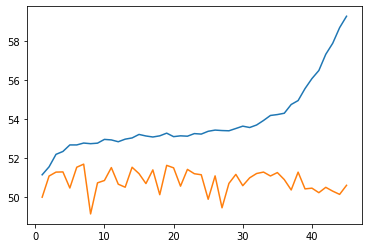

In [ ]:
ep_li = sorted(list(set(ep_li)))
plt.plot(ep_li[:], acc_list)
plt.plot(ep_li[:], test_acc_list)
plt.show()

**Here, we evaluate the accuracy of our PyTorch model on our test data.**
*Currently working on this, model gives wrong train accuracy even though the presumably correct accuracy was printed during training loop.*

In [ ]:
def test_model(nd_feature_test_matrix, nd_y_test, model, criterion = nn.CrossEntropyLoss()):

  model.eval()

  #Here, we convert our NumPy test data to Torch Tensors.
  y_test_torch = torch.from_numpy(nd_y_test).type(torch.LongTensor)
  feature_test_matrix = torch.from_numpy(nd_feature_test_matrix).type(torch.DoubleTensor)
  
  #This code below can be uncommented in order to load the model instead of retraining it from before.
  #PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.994.pth"
  #model = LinearModel()
  #model.load_state_dict(torch.load(PATH))

  #Initialize accuracy to 0.
  acc = 0
  with torch.no_grad():
    #For each test example, perform forward propagation and compare the output with the label.
    for i in range(len(y_test_torch)):
      #Test feature vector.
      example = feature_test_matrix[i:i+1].type(torch.FloatTensor)
      #Forward Propagation evaluation of this feature vector.
      out = model(example)
      _, predicted = torch.max(out.data, 1)
      #assert out.argmax().item() == predictions[i], (predicted.item(), predictions[i])
      #This is the test label.
      label = y_test_torch[i]
      #If the prediction is correct, we increment the accuracy.
      if(label.item()==out.argmax().item()):
        acc+=1
      #We calculate the loss for the prediction/label.
      loss_label = torch.Tensor([label]).type(torch.LongTensor)
      loss = criterion(out, loss_label)

  #Normalize the accuracy count to get a measure of accuracy percentage.
  acc/=len(y_test_torch)

  print("ACCURACY (%): ", acc*100)

  pass

#Let us test our current model
test_model(feature_train_matrix, y_train, model)

#Uncomment this code to store the model.

#csv_model = pd.DataFrame(model.state_dict())
#csv_model = csv_model.to_csv("model1.csv")
#files.download("model1.csv")
#torch.save(model,"./")

Here, we save training and testing data in csvs as well as saving the PyTorch model.

In [ ]:
from google.colab import files
from google.colab import drive

#Here, we download the train/test data csvs
#files.download("csv_train.csv")
#files.download("csv_test.csv")

drive.mount('/content/gdrive')

#Uncomment to save the torch models to these locations.

#torch.save(model.state_dict(), '/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.994.pth')
#torch.save(model.state_dict(), '/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth')

## **Triangular Lattices**

While it is indeed surprising that a neural network is well able to model this statistical phenomenon, 
it's most surprising capability is its ability to generalize well to lattices of other structures, like triangular lattices. 

In order to demonstrate this, we generate a dataset of triangular lattices to test our model (trained on square lattices).

We generate triangular lattices via two methods: Using a hexagonal filter and Exploiting MatPlotLib's visualization capabilities.

###**Approach 1: Hexagonal Filters**

The triangular hamiltonian is a dependent on the similarity of spins of neighbors of each lattice site.
[Obtained from cursory reading of *Ising Model on a Triangular Lattice
with Three-spin Interactions. I The Eigenvalue Equation (Baxter et. al 1974)*].

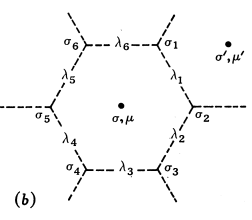

*This illustration of a single lattice site
 and the sites who it is related to in the calculation of the Triangular Hamiltonian is from the above mentioned paper.*

First, we write a function to calculate the Hamiltonian of a particular lattice.

In [ ]:
@jit
def triang_energy(lattice):
  en = 0
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      #First, we account for neighboring sites 1 and 2, which together with the center form a triangle.
      if i<len(lattice) - 1

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      if (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      if (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      if (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      if (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      if (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

Here, we run the Metropolis-Hastings algorithm to generate triangular lattices.

In [ ]:
sampleList, tempList, enList, timeList = metropolis(triang_energy, 40, 10, 100, 1, 3.7, 1000)

In [ ]:
grid_size = 40
grid = np.zeros((grid_size, grid_size)) > np.ones((grid_size, grid_size))
grid_length = grid_size - grid_size // 3
for i in range(grid_length//2):
  for j in range((grid_size-1)//3 - i,2*(grid_size-1)//3 + i):
    grid[i][j] = True
for i in range(grid_length//2,grid_length):
  k = i - grid_length//2
  init_left = (grid_size - 1)//3 - grid_length//2 
  init_right = 2*(grid_size - 1)//3 + grid_length//2
  for j in range(init_left+ k,init_right - k):
    grid[i][j] = True
plt.figure(figsize=(grid_size,grid_size))
plt.imshow(grid)
plt.show()

First, we generate triangular lattices, in the sense that it has a Triangular Hamiltonian. But we still generate square spins.

In [ ]:
from google.colab import files
files.upload() #Here, we reload our PyTorch model so that we don't need to retrain it each time.

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  #Hexagonal Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      if (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      if (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      if (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      if (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      if (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

grid_size = 40
starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
sampleList[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0

In [ ]:
PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth"
# Load
model = LinearModel()
model.load_state_dict(torch.load(PATH))
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    #loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

Then, we generate Triangular Lattices in a hexagonal shape, but allow to try to flip the zero spins. (Zero spins just represent nothing; we are using them to outline the hexagons)

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  #Hexagonal Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      elif (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      elif (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      elif (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      elif (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      elif (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      for i in range(grid_size):
        for j in range(grid_size):
          if not grid[i][j]:
            lattice[i][j] = 0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
sampleList[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0

In [ ]:
PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth"
# Load
model = LinearModel()
model.load_state_dict(torch.load(PATH))
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    #loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

Now we generate Triangular Lattices, in a hexagonal shape. (The other elements in the lattice are 0s, no spins)

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  #Hexagonal Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      if (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      if (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      if (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      if (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      if (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      for i in range(grid_size):
        for j in range(grid_size):
          if not grid[i][j]:
            lattice[i][j] = 0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        while lattice[flip_x][flip_y]==0:
          flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
sampleList[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0

In [ ]:
PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth"
# Load
model = LinearModel()
model.load_state_dict(torch.load(PATH))
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    #loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

## **Triangular Lattice Regeneration**

Here, we try to generate data on square lattices.

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en -= lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en -= lattice[i][j]*lattice[i+1][j]
      if j>0:
        en -= lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en -= lattice[i][j] * lattice[i][j+1]
  return en

grid_size = 2 #The grid size.
starts = 1 #For each temperature. 10
samples = 1 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 10 #100
tempList = []
sampleList = []
imList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
fig = plt.figure(figsize=(grid_size,grid_size))
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])
      plt.imshow(lattice)
      tempList.append(temp)
len(sampleList), loopCount
fig = plt.figure()
ani = animation.ArtistAnimation(fig, imList, interval=50, blit=True,
                                repeat_delay=1000)

## **Square Ice Model:**

###**Generating Square Ice Lattices via Metropolis_Hastings.**

First, we create a get_energy function to calculate the energy of a Square Ice Lattice:

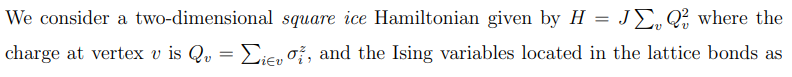

In [ ]:
@jit
def sq_ice_energy(lattice):
  en = 0
  for vi in range(1, len(lattice) - -1):
    for wi in range(1, len(lattice) - 1):
      v = lattice[vi][wi]
      charge_v = lattice[vi][wi - 1] + lattice[vi][wi + 1] + lattice[vi + 1][wi] + lattice[vi - 1][wi]
      en+= charge_v**2
  return en

Now we apply the Metropolis-Hastings method to generate Square Ice Lattice samples.

In [ ]:
sampleList, tempList, enList, timeList =  metropolis(sq_ice_energy, 16, 10, 100, 1.0, 3.7, 100)

In [ ]:
feature_train_matrix, y_train, feature_test_matrix, y_test = train_test_data(sampleList)

In [ ]:
from sklearn import svm 
clf = svm.SVC(kernel="rbf") 
clf.fit(feature_train_matrix,y_train)
predictions = clf.predict(feature_test_matrix)
from sklearn import metrics
print(metrics.accuracy_score(y_test,predictions)) 

## **Ising Lattice Gauge Theory:**

In [43]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
!pip install tqdm
from tqdm import tqdm
@jit
def get_energy(lattice):
  en = 0
  #For each plaquette in lattice, add the product of its vertices' spins to en
  plaquettes = gen_plaquette(lattice) 
  for p in plaquettes: #[[1,-1],[-1,1]]
    en += p[0][0] * p[0][1] * p[1][0] * p[1][1]
  return en

@jit
def gen_plaquette(lattice):
  plaqs = []
  for i in range(len(lattice) - 2):
    for j in range(len(lattice[i]) - 2):
      plaqs.append(lattice[i:i+2, j:j+2])
  return plaqs

@jit
def get_energy_2(lattice):
  en = 0
  for i in range(len(lattice) - 2):
    for j in range(len(lattice)-2):
      en += lattice[i][j] * lattice[i + 1][j] * lattice[i][j + 1] * lattice[i + 1][j + 1]
  return en

grid_size = 16 #The grid size.
starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
frames = []
imList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
fig = plt.figure(figsize=(grid_size,grid_size))
for temp_i in tqdm(range(len(temp_range))):
  temp = temp_range[temp_i]
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy_2(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy_2(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 27/27 [01:31<00:00,  3.38s/it]


<Figure size 1152x1152 with 0 Axes>

In [ ]:
import cv2
duration = 60
fps = len(sampleList)//duration
out = cv2.VideoWriter('gauge_lattice.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (grid_size, grid_size), False)
for i in range(len(sampleList)):
  frame = np.uint8(255 * sampleList[i])
  out.write(frame)
out.release()

In [ ]:
from google.colab import files
files.download('gauge_lattice.mp4')

Here, a Convolutional Neural Network on the Ising Gauge Theory Lattice, ideally to produce near 100% accuracy.

Preprocessing: Here, we convert the 16x16 lattices generated into a tensor of shape 16x16x2, with each of the two values doing one-hot encoding of each spin.


In [44]:
trainx_tensor = torch.zeros(1, grid_size, grid_size, 2) #16 x 16 x 2 x 1

for lattice in sampleList:
  pos_mat = torch.tensor(lattice>0, dtype = torch.float32)
  neg_mat = torch.tensor(lattice<0, dtype = torch.float32)
  combined_tensor = torch.stack((pos_mat, neg_mat))
  combined_tensor = torch.transpose(combined_tensor, dim0 = 0, dim1 = 2)
  combined_tensor = torch.unsqueeze(combined_tensor, 0) #16 x 16 x 2 x 1

  trainx_tensor = torch.cat((trainx_tensor, combined_tensor), dim = 0)

In [50]:
trainx_tensor = trainx_tensor[1:]

torch.Size([26999, 16, 16, 2])

In [53]:
Tc = 2.27
zero_states = trainx_tensor[torch.tensor(tempList) < Tc]

In [54]:
print(zero_states.shape)

torch.Size([12999, 16, 16, 2])


## **Generating New Test Sets: **

In [2]:
# (2)



NameError: ignored